In [2]:
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [3]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('acc') >= 0.96):   
            print("Reached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [4]:
EPOCHS =100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((224, 224))
#image_size = 0
width=224
height=224
depth=3
train_dir=r"C:\Users\Glau\Desktop\marine_new\Augmentation\Train"
valid_dir=r"C:\Users\Glau\Desktop\marine_new\Augmentation\Test"
train_folder=listdir(train_dir)
valid_folder=listdir(valid_dir)

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
callbacks = MyCustomCallback()

In [6]:
train_image_list, train_image_label= [], []
for disease_folder in train_folder:
    print(f"processing {disease_folder} ...")
    disease_img_folder= listdir(f"{train_dir}/{disease_folder}")
    #print(disease_img_folder)
    for disease_img in disease_img_folder:
    #for disease_img in disease_img_folder[: : 2]:    
        image_directory = f"{train_dir}/{disease_folder}/{disease_img}"
        if image_directory.endswith(".jpg") == True or image_directory.endswith(".TIFF") == True:
            train_image_list.append(convert_image_to_array(image_directory))
            train_image_label.append(disease_folder)
print("[INFO] Image loading completed")

processing Amphidinium carterae ...
processing Chatonella marina ...
processing Cochlodinium ...
processing Coolia monotis ...
processing Dinophysis forti ...
processing Gambierdiscus toxicus ...
processing Gymnodinium catenatum ...
processing Karenia brevis ...
processing Karlodinium ...
processing Lyngbya majuscula ...
processing Ostreopsis siamensis ...
processing Protoceratium reticulatum ...
processing Prymnesium parvum ...
processing Pseudo-nitzschia fraudulenta ...
processing Tolypothrix conglutinata ...
[INFO] Image loading completed


In [7]:
print(len(train_image_label))

72000


In [8]:
valid_image_list, valid_image_label= [], []
for disease_folder in valid_folder:
    print(f"processing {disease_folder} ...")
    disease_img_folder= listdir(f"{valid_dir}/{disease_folder}")
    for disease_img in disease_img_folder:
    #for disease_img in disease_img_folder[: : 2]: 
        image_directory = f"{valid_dir}/{disease_folder}/{disease_img}"
        if image_directory.endswith(".jpg") == True or image_directory.endswith(".TIFF") == True:
            valid_image_list.append(convert_image_to_array(image_directory))
            valid_image_label.append(disease_folder)
print("[INFO] Image loading completed")

processing Amphidinium carterae ...
processing Chatonella marina ...
processing Cochlodinium polykrikoides ...
processing Coolia monotis ...
processing Dinophysis forti ...
processing Gambierdiscus toxicus ...
processing Gymnodinium catenatum ...
processing Karenia brevis ...
processing Karlodinium ...
processing Lyngbya majuscula ...
processing Ostreopsis siamensis ...
processing Protoceratium reticulatum ...
processing Prymnesium parvum ...
processing Pseudo-nitzschia fradulenta ...
processing Tolypothrix conglutinata ...
[INFO] Image loading completed


In [9]:
print(len(valid_image_label))

18000


In [10]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
bin_train_image_labels = label_binarizer.fit_transform(train_image_label)
bin_valid_image_labels = label_binarizer.fit_transform(valid_image_label)
pickle.dump(label_binarizer,open('Label_Instance_marine_alex.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [11]:
print(n_classes)

15


In [12]:
np_train_image_list = np.array(train_image_list, dtype=np.float32) / 255.0
np_valid_image_list = np.array(valid_image_list, dtype=np.float32) / 255.0

In [13]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np
np.random.seed(1000)
#Instantiate an empty model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# 3rd Fully Connected Layer
#model.add(Dense(1000))
#model.add(Activation('relu'))
# Add Dropout
#model.add(Dropout(0.4))

# Output Layer
model.add(Dense(15))
model.add(Activation('softmax'))

model.summary()

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=["accuracy"])

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_2 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 384)        

In [17]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_2 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 384)        

In [18]:
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

print("[INFO] training network...")

[INFO] training network...


In [19]:
history=model.fit(np_train_image_list,bin_train_image_labels,
                  validation_data=(np_valid_image_list, bin_valid_image_labels),
                  batch_size=BS,
                  epochs=EPOCHS, verbose=1        
                  )

Train on 72000 samples, validate on 18000 samples
Epoch 1/100
72000/72000 [==============================] - 117s 2ms/step - loss: 2.6303 - accuracy: 0.0990 - val_loss: 2.5750 - val_accuracy: 0.1110
Epoch 2/100
72000/72000 [==============================] - 109s 2ms/step - loss: 2.5390 - accuracy: 0.1257 - val_loss: 2.5029 - val_accuracy: 0.1396
Epoch 3/100
72000/72000 [==============================] - 110s 2ms/step - loss: 2.4395 - accuracy: 0.1573 - val_loss: 2.3743 - val_accuracy: 0.1812
Epoch 4/100
72000/72000 [==============================] - 107s 1ms/step - loss: 2.2987 - accuracy: 0.2055 - val_loss: 2.1272 - val_accuracy: 0.2649
Epoch 5/100
72000/72000 [==============================] - 109s 2ms/step - loss: 1.9629 - accuracy: 0.3341 - val_loss: 1.6436 - val_accuracy: 0.4507
Epoch 6/100
72000/72000 [==============================] - 108s 2ms/step - loss: 1.5106 - accuracy: 0.4934 - val_loss: 1.3236 - val_accuracy: 0.5499
Epoch 7/100
72000/72000 [==============================]

In [20]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(np_valid_image_list, bin_valid_image_labels)
print(f"Test Accuracy: {scores[1]*100}")


[INFO] Calculating model accuracy
18000/18000 [==============================] - 17s 971us/step
Test Accuracy: 97.42777943611145


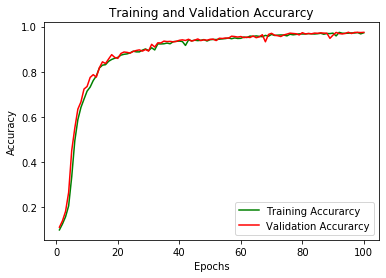

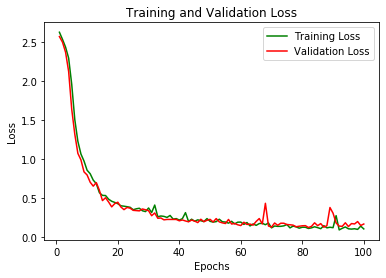

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'g', label='Training Accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation Accurarcy')
plt.title('Training and Validation Accurarcy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
ycalculated = model.predict(np_valid_image_list)

In [26]:
yhat_classes =np.argmax(ycalculated,axis=1)

In [27]:
import numpy as np
rounded_labels=np.argmax(bin_valid_image_labels,axis=1)


In [28]:
from sklearn.metrics import accuracy_score,classification_report 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer
#import seaborn as sns
#y_pred=model.predict_classes(np_valid_image_list)
#con_mat = tf.math.confusion_matrix(labels=y_true, predictions=ycalculated).numpy()
#matrix = confusion_matrix(rounded_labels,yhat_classes)
#y_pred=model.predict(np.array(val_image_list))
#yhat_classes = ["honda", "chevrolet", "honda", "toyota", "toyota", "chevrolet"]
#rounded_labels = ["honda", "chevrolet", "honda", "toyota", "toyota", "honda"]
cm =confusion_matrix(rounded_labels,yhat_classes)  

#matrix =confusion_matrix(bin_val_image_labels.argmax(axis=1), ycalculated)
print(cm)

[[1114    0    0    1    0    1    0    0    1    1    1    1    1    0
    79]
 [   0 1186    0    0    2    1    2    2    1    0    3    3    0    0
     0]
 [   0    0 1200    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   2    0    0 1195    0    2    0    0    0    0    1    0    0    0
     0]
 [   2    5    1    1 1123    1    0    3    4    0    2    1    0    4
    53]
 [   1    1    0    0    0 1192    0    0    2    0    1    1    1    0
     1]
 [   0    1    0    3    0    0 1193    0    0    0    1    0    0    1
     1]
 [   1    0    1    0    1    0    0 1194    1    0    0    1    0    0
     1]
 [   2    1    0    0    1    0    0    1 1148    0    0    3    0    0
    44]
 [   0    0    2    0    0    0    0    0    0 1193    0    0    0    3
     2]
 [   0    2    0    0    0    1    0    0    2    0 1178    0    0    0
    17]
 [   1    1    0    1    1    2    0    0    1    0    4 1189    0    0
     0]
 [   1    0    0    0    0    0    0    

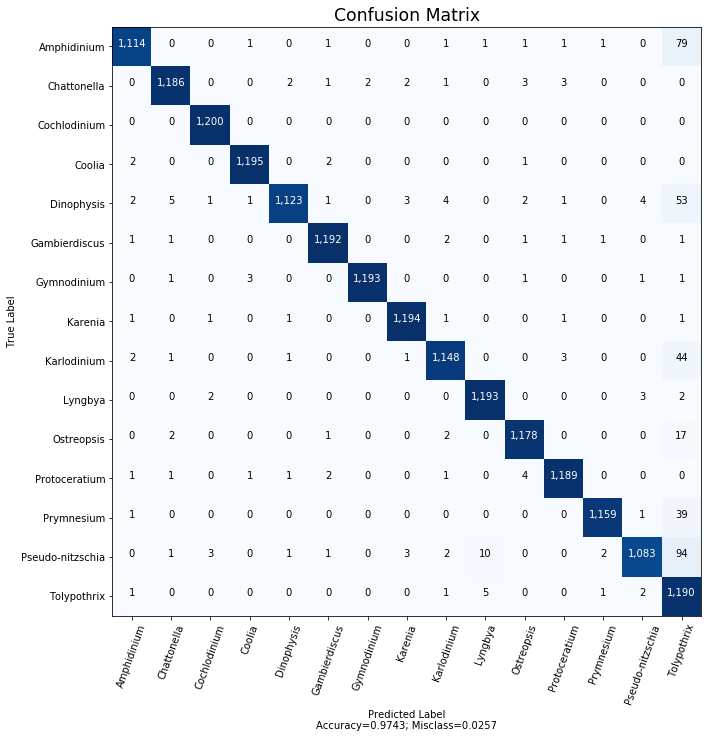

In [29]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'xx-large')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=70)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label\nAccuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(cm, 
                      normalize = False,
                      target_names=['Amphidinium','Chattonella','Cochlodinium','Coolia','Dinophysis','Gambierdiscus','Gymnodinium','Karenia','Karlodinium','Lyngbya',
 'Ostreopsis','Protoceratium','Prymnesium','Pseudo-nitzschia','Tolypothrix'],
                      title        = "Confusion Matrix")

In [30]:
from sklearn.metrics import accuracy_score,classification_report 
target_names =['Amphidinium','Chattonella','Cochlodinium','Coolia','Dinophysis','Gambierdiscus','Gymnodinium','Karenia','Karlodinium','Lyngbya',
 'Ostreopsis','Protoceratium','Prymnesium','Pseudo-nitzschia','Tolypothrix']
print(classification_report(rounded_labels, yhat_classes, target_names=target_names))

                  precision    recall  f1-score   support

     Amphidinium       0.99      0.93      0.96      1200
     Chattonella       0.99      0.99      0.99      1200
    Cochlodinium       0.99      1.00      1.00      1200
          Coolia       1.00      1.00      1.00      1200
      Dinophysis       0.99      0.94      0.96      1200
   Gambierdiscus       0.99      0.99      0.99      1200
     Gymnodinium       1.00      0.99      1.00      1200
         Karenia       0.99      0.99      0.99      1200
     Karlodinium       0.99      0.96      0.97      1200
         Lyngbya       0.99      0.99      0.99      1200
      Ostreopsis       0.99      0.98      0.99      1200
   Protoceratium       0.99      0.99      0.99      1200
      Prymnesium       1.00      0.97      0.98      1200
Pseudo-nitzschia       0.99      0.90      0.94      1200
     Tolypothrix       0.78      0.99      0.87      1200

        accuracy                           0.97     18000
       macro

In [31]:
class_to_label_map={ 0:'Amphidinium',1:'Chattonella',2:'Cochlodinium',3:'Coolia',4:'Dinophysis',5:'Gambierdiscus',6:'Gymnodinium',7:'Karenia',8:'Karlodinium',9:'Lyngbya',
 10:'Ostreopsis',11:'Protoceratium',12:'Prymnesium',13:'Pseudo-nitzschia',14:'Tolypothrix'}

C:\Users\Glau\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


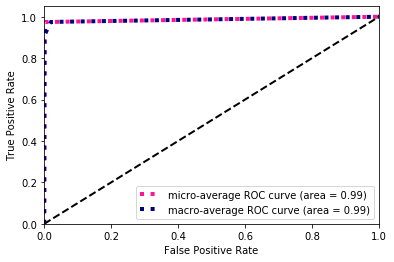

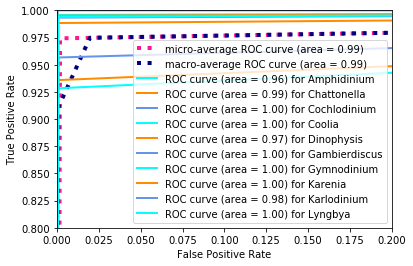

In [34]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

n_classes =15

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
lb = LabelBinarizer()
lb.fit(rounded_labels)
y_test= lb.transform(rounded_labels)
snn_pred = lb.transform(yhat_classes)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], snn_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), snn_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes-97), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
#plt.figure(figsize=(10,10)
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(10), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_to_label_map[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw,color='white')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic of Cell')
plt.legend(loc="lower right")
plt.show()

In [35]:
model.save('mariene_final_Alex_net.h5')

C:\Users\Glau\.conda\envs\tensorflow\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
